In [51]:
# Import Libraries

import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("ggplot")

import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...


True

In [88]:
pip install transformers

  Using cached transformers-4.25.1-py3-none-any.whl (5.8 MB)
  Using cached huggingface_hub-0.11.1-py3-none-any.whl (182 kB)
Note: you may need to restart the kernel to use updated packages.


In [104]:
# more imports
import torch
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax 

### Part 1: Data Collection Using Web Scraping

In [ ]:
pip install BeautifulSoup4

In [16]:
url = "https://www.amazon.co.uk/product-reviews/B09WD2YNH6/ref=cm_cr_arp_d_paging_btm_next_330?ie=UTF8&reviewerType=all_reviews&pageNumber=1"

def cook_soup(url):
    request = requests.get("http://localhost:8050/render.html", params = {"url":url, "wait":2})
    soup = BeautifulSoup(request.text, "html.parser")

    return soup

In [17]:
soup = cook_soup(url)
print(soup.title.text)

Amazon.co.uk:Customer reviews: Top Gun: Maverick


In [19]:
review_list = []
def collect_reviews(soup):
    reviews = soup.find_all("div", {"data-hook": "review"})

    try:
        for item in reviews:
            review = {
                "product": soup.title.text.replace("Amazon.co.uk:Customer reviews:", "").strip(),
                "title": item.find("a", {"data-hook": "review-title"}).text.strip(),
                "rating": float(item.find("i", {"data-hook": "review-star-rating"}).text.replace("out of 5 stars", "").strip()),
                "body": item.find("span", {"data-hook": "review-body"}).text.strip()
            }

            review_list.append(review)
    except:
        pass
    
# Go through several pages to generate review data    
for x in range(1,400):
    soup = cook_soup(f'https://www.amazon.co.uk/product-reviews/B09WD2YNH6/ref=cm_cr_arp_d_paging_btm_next_330?ie=UTF8&reviewerType=all_reviews&pageNumber={x}')
    print(f'loading page: {x}')
    collect_reviews(soup)
    print(len(review_list))
    if not soup.find("li", {"class": "a-disabled a-last"}):
        pass
    else:
        break
        
        
# Create a DataFrame and save to excel 
df = pd.DataFrame(review_list)
df.to_excel("maverick-reviews.xlsx", index=False)
print("Finish.")

loading page: 1
10
loading page: 2
20
loading page: 3
30
loading page: 4
40
loading page: 5
50
loading page: 6
60
loading page: 7
70
loading page: 8
80
loading page: 9
90
loading page: 10
100
loading page: 11
110
loading page: 12
120
loading page: 13
130
loading page: 14
140
loading page: 15
150
loading page: 16
160
loading page: 17
170
loading page: 18
180
loading page: 19
190
loading page: 20
200
loading page: 21
210
loading page: 22
220
loading page: 23
230
loading page: 24
240
loading page: 25
250
loading page: 26
260
loading page: 27
270
loading page: 28
280
loading page: 29
290
loading page: 30
300
loading page: 31
310
loading page: 32
320
loading page: 33
330
loading page: 34
340
loading page: 35
350
loading page: 36
360
loading page: 37
370
loading page: 38
380
loading page: 39
390
loading page: 40
400
loading page: 41
410
loading page: 42
420
loading page: 43
430
loading page: 44
440
loading page: 45
450
loading page: 46
460
loading page: 47
470
loading page: 48
480
loading pa

### Part 2: Exploratory Data Analysis

In [21]:
# Read Data
df = pd.read_excel("maverick-reviews.xlsx")
df.head()

,product,title,rating,body
0,Top Gun: Maverick,You Told Me Not To Think!,5,Top Gun MaverickIN A SENTENCEWell worth the wa...
1,Top Gun: Maverick,"633 Squadron with jets, ray-bans and Tom Cruis...",3,No spoilersRotten Tomatoes has this at over 90...
2,Top Gun: Maverick,Breaks the curse of the sequel,5,Often sequels are a disappointment. TGM is not...
3,Top Gun: Maverick,Hold on to your seats this I a full throttle m...,5,Didn't think it was possible to better an icon...
4,Top Gun: Maverick,TOP DRAWER ENTERTAINMENT,5,The kinda' next episode in the TOP GUN franchi...


In [24]:
df.shape

(3018, 4)

In [32]:
df["body"].values[0]

'Top Gun MaverickIN A SENTENCEWell worth the watch, something for everyone, it works as a great ‘date flick’ or  for a quiet night in on the sofa.BIAS +This is a movie franchise that has bookended my working life in much the same way it bookended Maverick’s, we’re the same age but a full career as a 🇬🇧 Army Combat Medic isn’t as telegenic 😂 It is a poorly kept secret that having been a very, very minor Army Celebrity I tried first for the Fleet Air Arm and it now shames me to say, the Royal Air Force 😔  before the Army that at the time were deeply suspicious of academic achievement and took me in. Sadly, my lack of secondary schooling meant that I couldn’t fly with the Army Air Corps either, I love aviation.  I say this purely to lay out my conscious positive bias.OVERVIEWThis is a great Big Movie with all the sweeping scenery and elaborate air combat sequences but it’s also a great Little Movie with the personal storylines of the characters. The script is more grown up, the legacy cha

In [27]:
df["rating"].value_counts().sort_index()

1      56
2      28
3     149
4     279
5    2506
Name: rating, dtype: int64

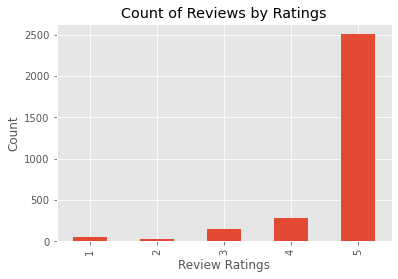

In [30]:
df["rating"].value_counts().sort_index().plot(kind="bar", title="Count of Reviews by Ratings")
plt.xlabel("Review Ratings")
plt.ylabel("Count");

In [33]:
# Basic NLTK
example = df["body"][25]
print(example)

This is quite simply my favourite movie of all time. I'm a movie fan I had about a thousand movies on dvd and it was my passion to be entertained with good movies and tv for decades. It was part of my life and a way to escape and watch quality program with little or no hidden msgs of politics and inclusion. I subscribed to all the streaming services to continue this legacy in a more modern way but Hollywood is nothing but thickle mistress and in today's lack of entertainment it seems that political msgs and diversity and exclusive casting takes president over fans entertainment and good story telling. BUT WAIT, like a phoenix rising from the ashes Top Gun Maverick is quite simply Awesome with a side of Awesomeness thrown in to entertain you to the point you are in Awesome heaven. Tom Cruise is the last great Hollywood actor who cares more about action, stunts, fans and making a great movie with likeable characters and a great story rather than a political, ideological snooze fest of a 

In [37]:
tokens = nltk.word_tokenize(example)
tokens[:10]

['This',
 'is',
 'quite',
 'simply',
 'my',
 'favourite',
 'movie',
 'of',
 'all',
 'time']

In [41]:
# Check the part of speech of each word
tagged = nltk.pos_tag(tokens)
tagged[:10]

[('This', 'DT'),
 ('is', 'VBZ'),
 ('quite', 'RB'),
 ('simply', 'RB'),
 ('my', 'PRP$'),
 ('favourite', 'JJ'),
 ('movie', 'NN'),
 ('of', 'IN'),
 ('all', 'DT'),
 ('time', 'NN')]

In [49]:
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

(S
  This/DT
  is/VBZ
  quite/RB
  simply/RB
  my/PRP$
  favourite/JJ
  movie/NN
  of/IN
  all/DT
  time/NN
  ./.
  I/PRP
  'm/VBP
  a/DT
  movie/NN
  fan/NN
  I/PRP
  had/VBD
  about/IN
  a/DT
  thousand/NN
  movies/NNS
  on/IN
  dvd/NN
  and/CC
  it/PRP
  was/VBD
  my/PRP$
  passion/NN
  to/TO
  be/VB
  entertained/VBN
  with/IN
  good/JJ
  movies/NNS
  and/CC
  tv/NN
  for/IN
  decades/NNS
  ./.
  It/PRP
  was/VBD
  part/NN
  of/IN
  my/PRP$
  life/NN
  and/CC
  a/DT
  way/NN
  to/TO
  escape/VB
  and/CC
  watch/VB
  quality/NN
  program/NN
  with/IN
  little/JJ
  or/CC
  no/DT
  hidden/JJ
  msgs/NN
  of/IN
  politics/NNS
  and/CC
  inclusion/NN
  ./.
  I/PRP
  subscribed/VBD
  to/TO
  all/PDT
  the/DT
  streaming/NN
  services/NNS
  to/TO
  continue/VB
  this/DT
  legacy/NN
  in/IN
  a/DT
  more/RBR
  modern/JJ
  way/NN
  but/CC
  (PERSON Hollywood/NNP)
  is/VBZ
  nothing/NN
  but/CC
  thickle/NN
  mistress/NN
  and/CC
  in/IN
  today/NN
  's/POS
  lack/NN
  of/IN
  entertainment/N

### Sentiment Analysis

VADER(Valence Aware Dictionar and Sentiment Reasoner)- Bag of words approach(
stop wprds are removed
each word is scored and combined to a total score


In [52]:
sia = SentimentIntensityAnalyzer()

In [55]:
# test sentiment analyzer
sia.polarity_scores("I am so happy!")

{'neg': 0.0, 'neu': 0.318, 'pos': 0.682, 'compound': 0.6468}

In [56]:
sia.polarity_scores("This is the worst day ever!")

{'neg': 0.468, 'neu': 0.532, 'pos': 0.0, 'compound': -0.6588}

In [57]:
sia.polarity_scores("example")

{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

In [66]:
df.drop(columns = "id", inplace=True)

In [67]:
# Create a unique id for each column
id = range(1, len(df)+1)
df.insert(0, "id", id)

In [68]:
df.head()

,id,product,title,rating,body
0,1,Top Gun: Maverick,You Told Me Not To Think!,5,Top Gun MaverickIN A SENTENCEWell worth the wa...
1,2,Top Gun: Maverick,"633 Squadron with jets, ray-bans and Tom Cruis...",3,No spoilersRotten Tomatoes has this at over 90...
2,3,Top Gun: Maverick,Breaks the curse of the sequel,5,Often sequels are a disappointment. TGM is not...
3,4,Top Gun: Maverick,Hold on to your seats this I a full throttle m...,5,Didn't think it was possible to better an icon...
4,5,Top Gun: Maverick,TOP DRAWER ENTERTAINMENT,5,The kinda' next episode in the TOP GUN franchi...


In [72]:
# Run polarity score on the entire dataset
result = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    body = row["body"]
    myid = row["id"]
    result[myid] = sia.polarity_scores(body)

  0%|          | 0/3018 [00:00<?, ?it/s]

In [76]:
vaders = pd.DataFrame(result).T
vaders = vaders.reset_index().rename(columns={"index": "id"})
vaders = vaders.merge(df, how="left")

In [77]:
vaders.head()

,id,neg,neu,pos,compound,product,title,rating,body
0,1,0.086,0.768,0.147,0.9955,Top Gun: Maverick,You Told Me Not To Think!,5,Top Gun MaverickIN A SENTENCEWell worth the wa...
1,2,0.102,0.789,0.108,0.9238,Top Gun: Maverick,"633 Squadron with jets, ray-bans and Tom Cruis...",3,No spoilersRotten Tomatoes has this at over 90...
2,3,0.025,0.834,0.141,0.9523,Top Gun: Maverick,Breaks the curse of the sequel,5,Often sequels are a disappointment. TGM is not...
3,4,0.056,0.684,0.260,0.9959,Top Gun: Maverick,Hold on to your seats this I a full throttle m...,5,Didn't think it was possible to better an icon...
4,5,0.074,0.799,0.127,0.9021,Top Gun: Maverick,TOP DRAWER ENTERTAINMENT,5,The kinda' next episode in the TOP GUN franchi...


#### Assumption:
if the rating of a product is a 5 star, the review is going to be more positive. we can show this with a bar chart

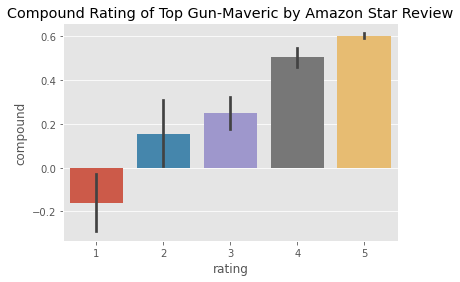

In [80]:
sns.barplot(data=vaders, x="rating", y="compound")
plt.title("Compound Rating of Top Gun-Maveric by Amazon Star Review");

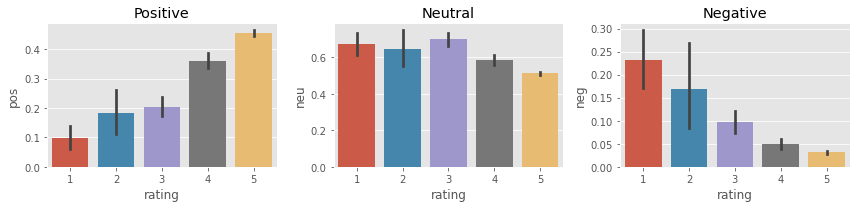

In [86]:
fig, axs = plt.subplots(1,3, figsize=(12,3))
sns.barplot(data=vaders, x="rating", y="pos", ax=axs[0])
sns.barplot(data=vaders, x="rating", y="neu", ax=axs[1])
sns.barplot(data=vaders, x="rating", y="neg", ax=axs[2])
axs[0].set_title("Positive")
axs[1].set_title("Neutral")
axs[2].set_title("Negative")
plt.tight_layout();

In [99]:
# positive 1-Star review
vaders[vaders["rating"] == 1].sort_values("pos", ascending=False)["body"].values[0]

'Loved everything, absolutely brilliant film'

In [108]:
# negative 5-Star review
vaders[vaders["rating"] == 5].sort_values("neg", ascending=False)["body"].values[0]

'No'

### Conclusion:
It was observed that there are some positive reviews with low ratings and some negative reviews with high ratings. this is because the vaders model uses the bag of word approach and doesn't consider the relationship between the words. A more intensive approach could be considered in future for better analysis